# Initialize

In [1]:
import os
import glob
import feather
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import anndata
import numpy as np
import copy
import openpyxl
import seaborn as sns
import nbimporter
import FFPE_helpers as ffpe
from harmony import harmonize

sns.set(font_scale=1.5)
sns.set_style("white")

sc.settings.figdir = 'FFPE/analysis/mouse_brain'
sc.set_figure_params(figsize=(6,5), dpi=100, frameon=False)
!mkdir -p sc.settings.figdir

# make cluster palette
ania_palette = ['#CAE8F6',
                '#006E82', 
                '#005AC8', 
                '#bcbcbc', 
                '#F0F032',
                '#14D2DC',
                '#AA0A3C',
                '#FA2800', 
                '#FA7850', 
                '#FA5078', 
                '#96B400',
                '#0AB45A',
                '#FA78FA',
                '#A0FA82',
                '#FAE6BE',
                '#c8befa',
                '#E69F00',
                '#8214A0',
                '#f6d48f',
                '#00A0FA',
                '#82A0BE'
               ]

# Comparison of deparaffinization optimizations via SCRB-seq

In [2]:
# scrb
ad_0719 = ffpe.import_feather("20190719_SCRB_rerun","scrb","190719")
ad_0719.write('FFPE/analysis/mouse_brain/SCRB_deparaffinization_comparison.h5ad')

        Sample SCRB_bc     i7_bc  num_nuclei treatment library_type seq_type  \
sample                                                                         
AM_1_1  AM_1_1  ATACTT  ACAAAGTG         100  XyleneRT         scrb     scrb   

       sample_batch  n_counts  n_genes  
sample                                  
AM_1_1       190719  137253.0    14415  
(64, 29659)


FFPE_helpers.ipynb:73: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  "            \n",
/home/jupyter/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
# ss2
ad_0821 = ffpe.import_feather("20190821_SS2","ss2","190821")

ad_0821 = ad_0821[ad_0821.obs['treatment'].isin(['Frozen','MinOil','Xylene','XyleneRT'])].copy()
ad_0821 = ad_0821[ad_0821.obs['library_type']=='ss2'].copy()
ad_0821 = ad_0821[ad_0821.obs['num_nuclei'].isin([10,50,100])].copy()

ad_0821.write('FFPE/analysis/mouse_brain/SS2_deparaffinization_comparison.h5ad')

        Sample     i5_bc     i7_bc  num_nuclei treatment library_type  \
sample                                                                  
SS2_A1  SS2_A1  ACTCGCTA  ATAGAGAG         500    Frozen          ss2   

       seq_type sample_batch  n_counts  n_genes  
sample                                           
SS2_A1      ss2       190821  386153.0    12755  
(45, 21987)


FFPE_helpers.ipynb:73: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  "            \n",
/home/jupyter/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
a = ad_0719
downsample_10 = min(a[(a.obs['treatment']=='Frozen')&(a.obs['num_nuclei']==10)].obs['n_counts'])
print(downsample_10)
downsample_100 = min(a[(a.obs['treatment']=='Frozen')&(a.obs['num_nuclei']==100)].obs['n_counts'])
print(downsample_100)

18159.0
59608.0


In [5]:
# downsample counts - different for 10 vs 100 nuclei
ad_0719_copy = ad_0719.copy()

# downsample_lims = [1000*i for i in ad_0719.obs['num_nuclei'].tolist()]
downsample_lims = ad_0719.obs['num_nuclei'].map({10:downsample_10, 
                               100:downsample_100}).tolist()

sc.pp.downsample_counts(ad_0719_copy, counts_per_cell=downsample_lims)

# calculate downsampled n_genes and n_counts
ad_0719_copy.obs['n_genes_ds'] = ad_0719_copy.X.astype(bool).sum(axis=1)
ad_0719_copy.obs['n_counts_ds'] = ad_0719_copy.X.sum(axis=1)

In [6]:
b = ad_0821
downsample_10 = min(b[(b.obs['treatment']=='Frozen')&(b.obs['num_nuclei']==10)].obs['n_counts'])
print(downsample_10)
downsample_50 = min(b[(b.obs['treatment']=='Frozen')&(b.obs['num_nuclei']==50)].obs['n_counts'])
print(downsample_50)
downsample_100 = min(b[(b.obs['treatment']=='Frozen')&(b.obs['num_nuclei']==100)].obs['n_counts'])
print(downsample_100)

891133.0
270363.0
466661.0


In [7]:
# downsample counts - differs by nuclei count
ad_0821_copy = ad_0821.copy()

# downsample_lims = [10000*i for i in ad_0821.obs['num_nuclei'].tolist()]
downsample_lims = ad_0821.obs['num_nuclei'].map({
                                        10:downsample_10, 
                                        50:downsample_50,
                                       100:downsample_100}).tolist()

sc.pp.downsample_counts(ad_0821_copy, counts_per_cell=downsample_lims)

# calculate downsampled n_genes and n_counts
ad_0821_copy.obs['n_genes_ds'] = ad_0821_copy.X.astype(bool).sum(axis=1)
ad_0821_copy.obs['n_counts_ds'] = ad_0821_copy.X.sum(axis=1)

In [8]:
def plot_genes_by_treatment(ad, seq_type, hue, plot_group='treatment', plot_feat='n_genes', savefig=True):
    if seq_type=='SCRB':
        hue_order=[10,100]
        box_pairs=[
            (("MinOil", 10), ("XyleneRT", 10)),
            (("MinOil", 100), ("XyleneRT", 100)),
            ]
        
    elif seq_type=='SS2':
        hue_order=[10,50,100],
        box_pairs=[
            (("MinOil", 'single'), ("XyleneRT", 'single')),
            (("MinOil", 'bulk'), ("XyleneRT", 'bulk')),
            ]

    fig, ax = plt.subplots(figsize=(5,5))
    sns.set(font_scale=1.2)
    sns.set_style("white")
    g = sns.barplot(x=plot_group,y=plot_feat,
                      data=ad.obs, 
                        facecolor=(1,1,1,0),
                        edgecolor='k',
                        linewidth=1,
                        hue=ad.obs[hue],
                        order=['Frozen','MinOil','Xylene','XyleneRT']
                        )
    g = sns.stripplot(x=plot_group,y=plot_feat,
                      data=ad.obs, 
                        jitter=True,
                        marker='o',
                        alpha=0.8,
                        edgecolor=None,
                        linewidth=1,
                        split=True,
                        hue=ad.obs[hue],
                        order=['Frozen','MinOil','Xylene','XyleneRT']
                        )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if plot_feat=='n_counts_ds': 
        plt.yticks(np.arange(0,180000,50000))
    elif plot_feat=='n_genes_ds':
        plt.yticks(np.arange(0,16000,5000))
    plt.xticks(rotation=90)
    # g.legend(loc='upper right', ncol=1, bbox_to_anchor=(1.45,0.5))
    g.legend_.remove()
    plt.tight_layout()
    if savefig:
        g.get_figure().savefig(bbox_inches='tight',
                           fname='%s/%s_deparaffin_methods_%s.pdf' %(sc.settings.figdir, seq_type, plot_feat))

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


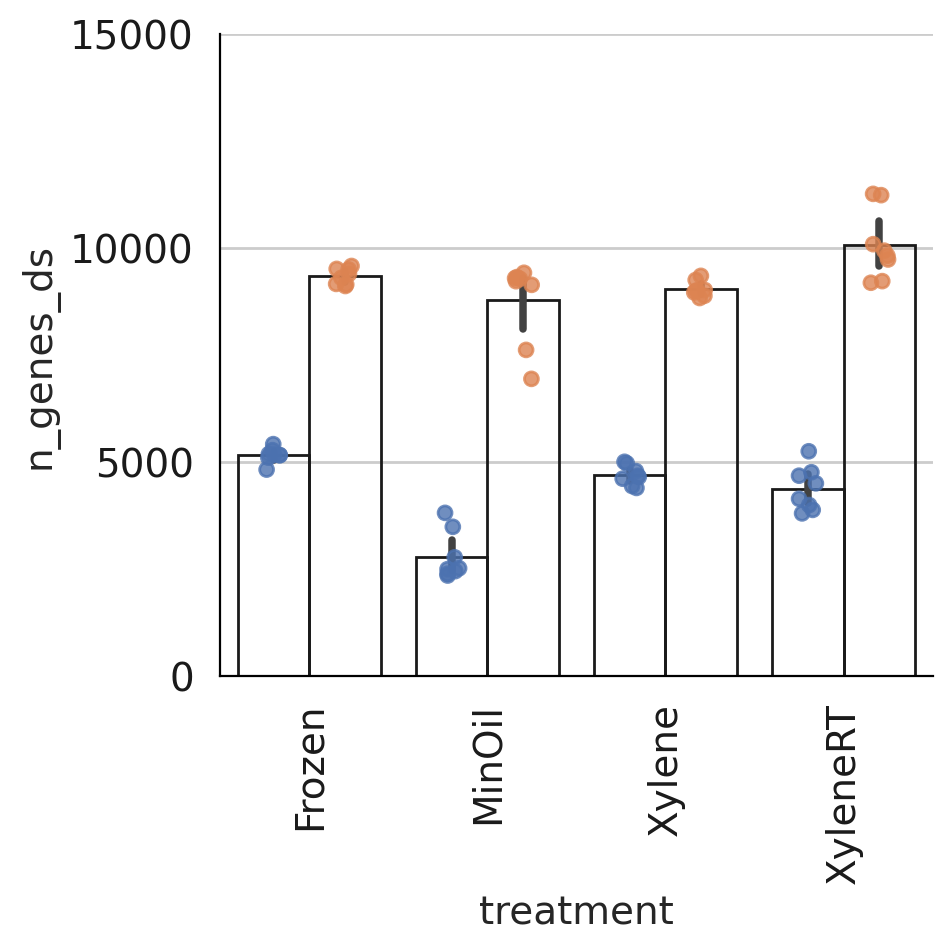

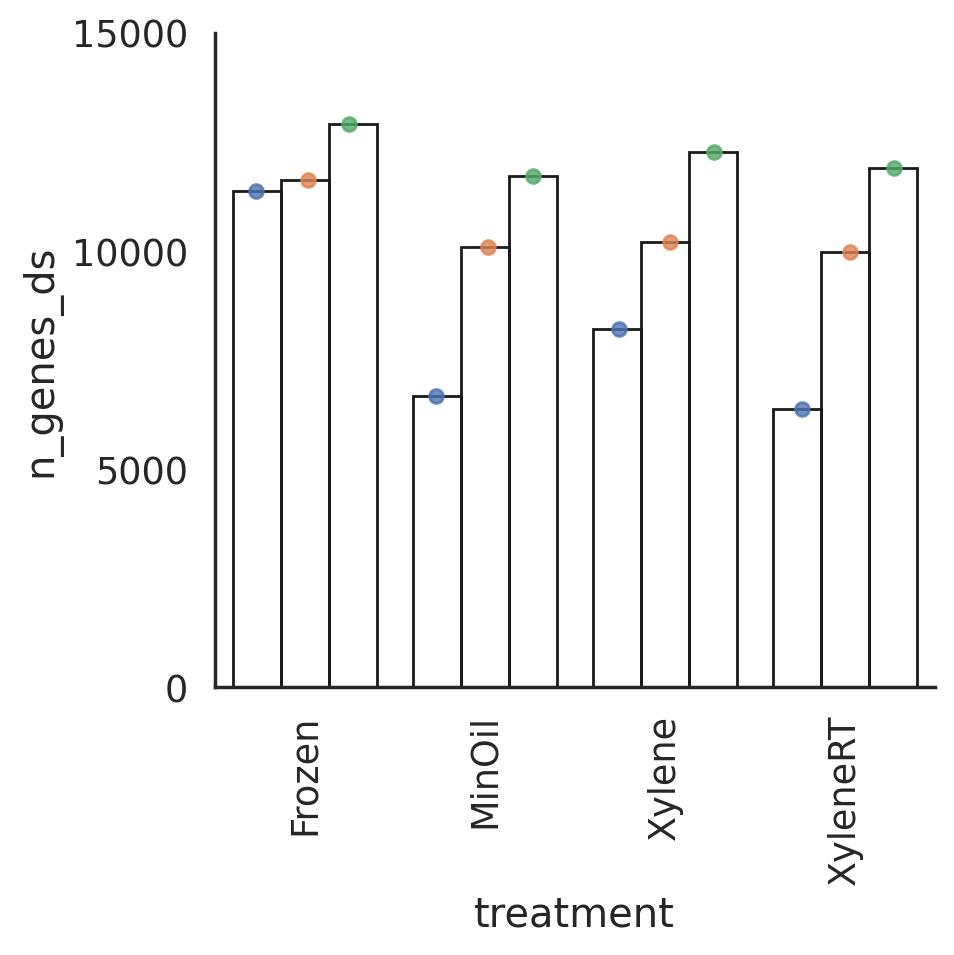

In [9]:
plot_genes_by_treatment(ad_0719_copy, 'SCRB', hue='num_nuclei', plot_feat='n_genes_ds', savefig=True)
plot_genes_by_treatment(ad_0821_copy, 'SS2', hue='num_nuclei', plot_feat='n_genes_ds', savefig=True)

## Compare SS2 and SCRB

(64, 10653)
(64, 19006)
Returned ad_hg19, ad_mm10, ad_all


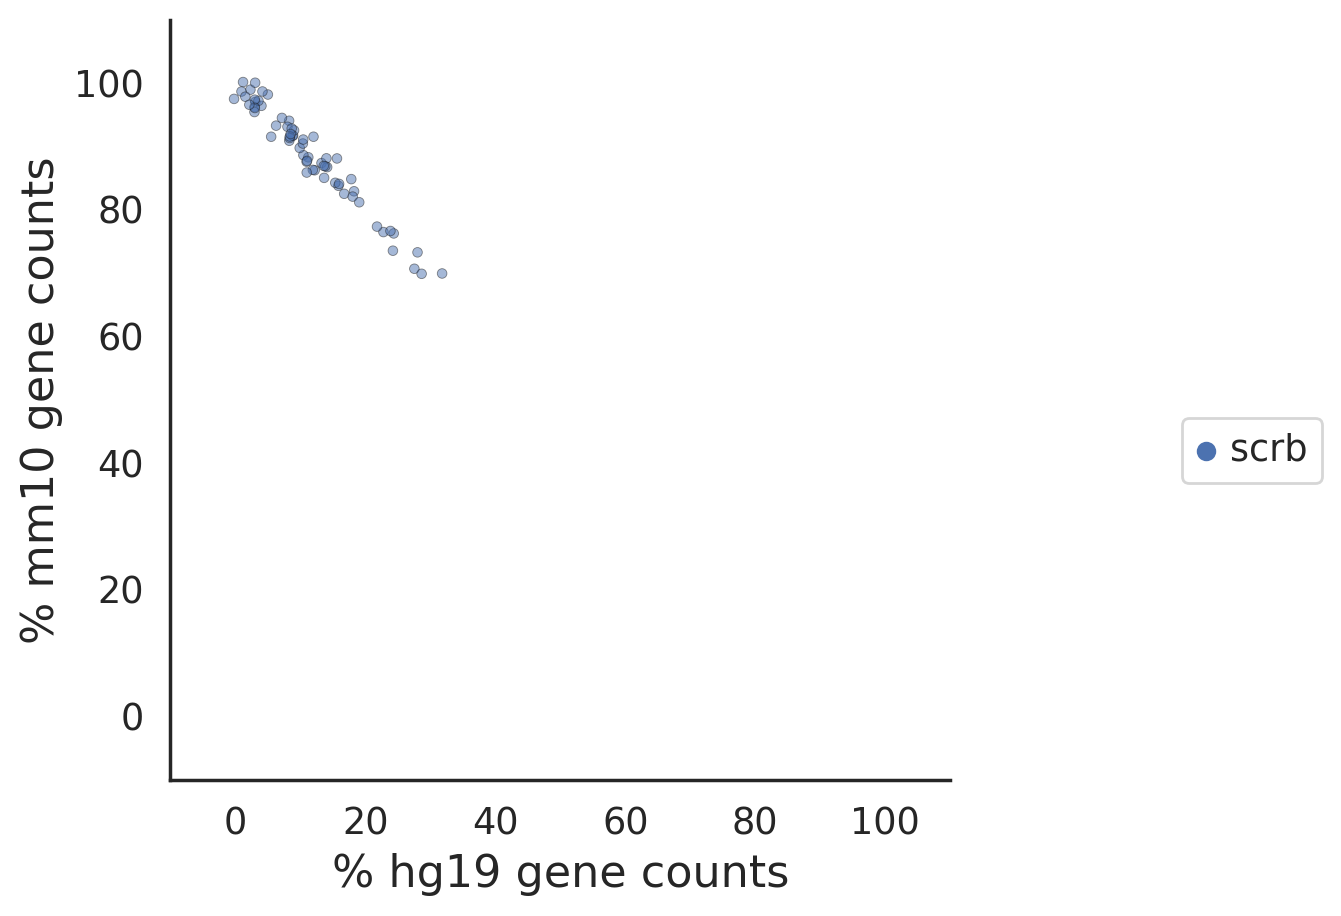

In [15]:
# split SCRB into hg19 and mm10
scrb_hg19, scrb_mm10, scrb_all = ffpe.split_hg19_and_mm10(ad_0719)
ffpe.scatter_hg19_vs_mm10(scrb_all, hue_var='library_type')
scrb_mm10.var_names_make_unique()

In [16]:
def downsample_ad(ad):
    downsample_10 = 50000
    downsample_100 = 50000
    downsample_lims = ad.obs['num_nuclei'].map({
                                    10:downsample_10, 
                                   100:downsample_100}).tolist()

    sc.pp.downsample_counts(ad, counts_per_cell=downsample_lims)

    # calculate downsampled n_genes and n_counts
    ad.obs['n_genes'] = ad.X.astype(bool).sum(axis=1)
    ad.obs['n_counts'] = ad.X.sum(axis=1)
    
scrb_mm10_ds = scrb_mm10[scrb_mm10.obs['num_nuclei'].isin([10,100])].copy()
downsample_ad(scrb_mm10_ds)

ss2_mm10_ds = ad_0821[ad_0821.obs['num_nuclei'].isin([10,100])].copy()
downsample_ad(ss2_mm10_ds)


In [17]:
scrb_10 = scrb_mm10_ds[(scrb_mm10_ds.obs['num_nuclei']==10)]
ss2_10 = ss2_mm10_ds[(ss2_mm10_ds.obs['num_nuclei']==10)]

scrb_100 = scrb_mm10_ds[(scrb_mm10_ds.obs['num_nuclei']==100)]
ss2_100 = ss2_mm10_ds[(ss2_mm10_ds.obs['num_nuclei']==100)]

In [18]:
df_bar = scrb_mm10_ds.obs.append(ss2_mm10_ds.obs)
n10_obs = scrb_10.obs.append(ss2_10.obs)
n100_obs = scrb_100.obs.append(ss2_100.obs)

In [20]:
plot_df

,Sample,SCRB_bc,i7_bc,num_nuclei,treatment,library_type,seq_type,sample_batch,n_counts,n_genes,n_counts_mm10,n_genes_mm10,percent_mm10,percent_hg19,i5_bc
sample,,,,,,,,,,,,,,,
AM_1_1,AM_1_1,ATACTT,ACAAAGTG,100,XyleneRT,scrb,scrb,190719,50000.0,9295,128394.0,11830.0,93.545494,6.454504,NaN
AM_1_2,AM_1_2,CTTCTG,ACAAAGTG,100,XyleneRT,scrb,scrb,190719,50000.0,8911,114265.0,10966.0,93.805161,6.194843,NaN
AM_1_3,AM_1_3,TTCCTC,ACAAAGTG,100,XyleneRT,scrb,scrb,190719,50000.0,7914,65002.0,8621.0,87.964165,12.035834,NaN
AM_1_4,AM_1_4,AGAATT,ACAAAGTG,100,XyleneRT,scrb,scrb,190719,50000.0,8143,55067.0,8358.0,89.959648,10.040351,NaN
AM_1_5,AM_1_5,CGACTT,ACAAAGTG,100,XyleneRT,scrb,scrb,190719,50000.0,7866,55049.0,8105.0,89.933182,10.066818,NaN
AM_1_6,AM_1_6,CGGAGG,ACAAAGTG,100,XyleneRT,scrb,scrb,190719,50000.0,8593,78490.0,9736.0,93.829201,6.170803,NaN
AM_1_7,AM_1_7,GCGTGG,ACAAAGTG,100,XyleneRT,scrb,scrb,190719,50000.0,8497,76093.0,9588.0,92.647202,7.352798,NaN
AM_1_8,AM_1_8,CGTCGC,ACAAAGTG,100,XyleneRT,scrb,scrb,190719,50000.0,9144,106173.0,11162.0,90.875862,9.124134,NaN
AM_3_1,AM_3_1,ATACTT,GTGATAGC,100,Xylene,scrb,scrb,190719,50000.0,7484,51955.0,7589.0,88.877296,11.122705,NaN


/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


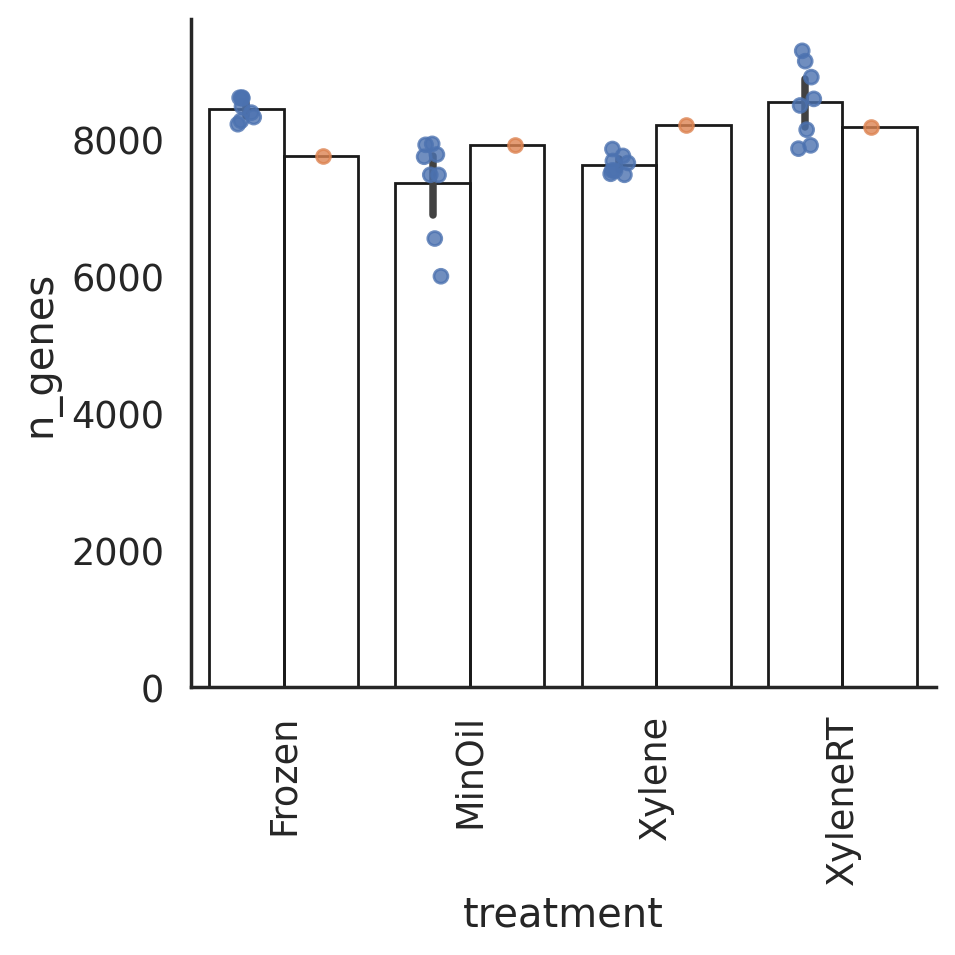

In [19]:
feat = 'n_genes'
plot_df = n100_obs

fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.2)
sns.set_style("white")
g = sns.barplot(x='treatment',
                y=feat,
                  data=plot_df, 
                    facecolor=(1,1,1,0),
                    edgecolor='k',
                    linewidth=1,
                    hue='library_type',
                    )
g = sns.stripplot(x='treatment',
                y=feat,
                  data=plot_df, 
                    jitter=True,
                    marker='o',
                    alpha=0.8,
                    edgecolor=None,
                    linewidth=1,
                    split=True,
                    hue='library_type',
                    )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=90)
g.legend_.remove()
plt.tight_layout()
plt.savefig('%s/scrb_vs_ss2_n100_%s.pdf' %(sc.settings.figdir, feat) )

In [9]:
hue_order = [10,100]
fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.2)
sns.set_style("white")
g = sns.barplot(x=plot_group,y=plot_feat,
                  data=ad.obs, 
                    facecolor=(1,1,1,0),
                    edgecolor='k',
                    linewidth=1,
                    hue=ad.obs[hue],
                    order=['Frozen','MinOil','Xylene','XyleneRT']
                    )
g = sns.stripplot(x=plot_group,y=plot_feat,
                  data=ad.obs, 
                    jitter=True,
                    marker='o',
                    alpha=0.8,
                    edgecolor=None,
                    linewidth=1,
                    split=True,
                    hue=ad.obs[hue],
                    order=['Frozen','MinOil','Xylene','XyleneRT']
                    )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if plot_feat=='n_counts_ds': 
    plt.yticks(np.arange(0,180000,50000))
elif plot_feat=='n_genes_ds':
    plt.yticks(np.arange(0,16000,5000))
plt.xticks(rotation=90)
# g.legend(loc='upper right', ncol=1, bbox_to_anchor=(1.45,0.5))
g.legend_.remove()
plt.tight_layout()
if savefig:
    g.get_figure().savefig(bbox_inches='tight',
                       fname='%s/%s_deparaffin_methods_%s.pdf' %(sc.settings.figdir, seq_type, plot_feat))

AnnData object with n_obs × n_vars = 64 × 29659
    obs: 'Sample', 'SCRB_bc', 'i7_bc', 'num_nuclei', 'treatment', 'library_type', 'seq_type', 'sample_batch', 'n_counts', 'n_genes', 'n_genes_ds', 'n_counts_ds'

# Comparison of frozen vs. FFPE from matched brain hemispheres

In [4]:
ad_ffpe_frozen = ffpe.import_feather('20210314_AM_SS2_mouse_brain_with_frozen','ss2','0314')
ad_ffpe_frozen.write('FFPE/analysis/mouse_brain/Frozen_vs_FFPE_SS2.h5ad')

FFPE_helpers.ipynb:73: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  "            \n",
/home/jupyter/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


                  i7_rc     i5_rc  num_nuclei plate brain library_type  \
sample                                                                   
brain_MB16_A1  ACTCGCTA  ATAGAGAG           1  MB16     L         FFPE   

              seq_type sample_batch  n_counts  n_genes  
sample                                                  
brain_MB16_A1      ss2         0314   16689.0      726  
(377, 41852)


(377, 18557)
(377, 23295)
Returned ad_hg19, ad_mm10, ad_all


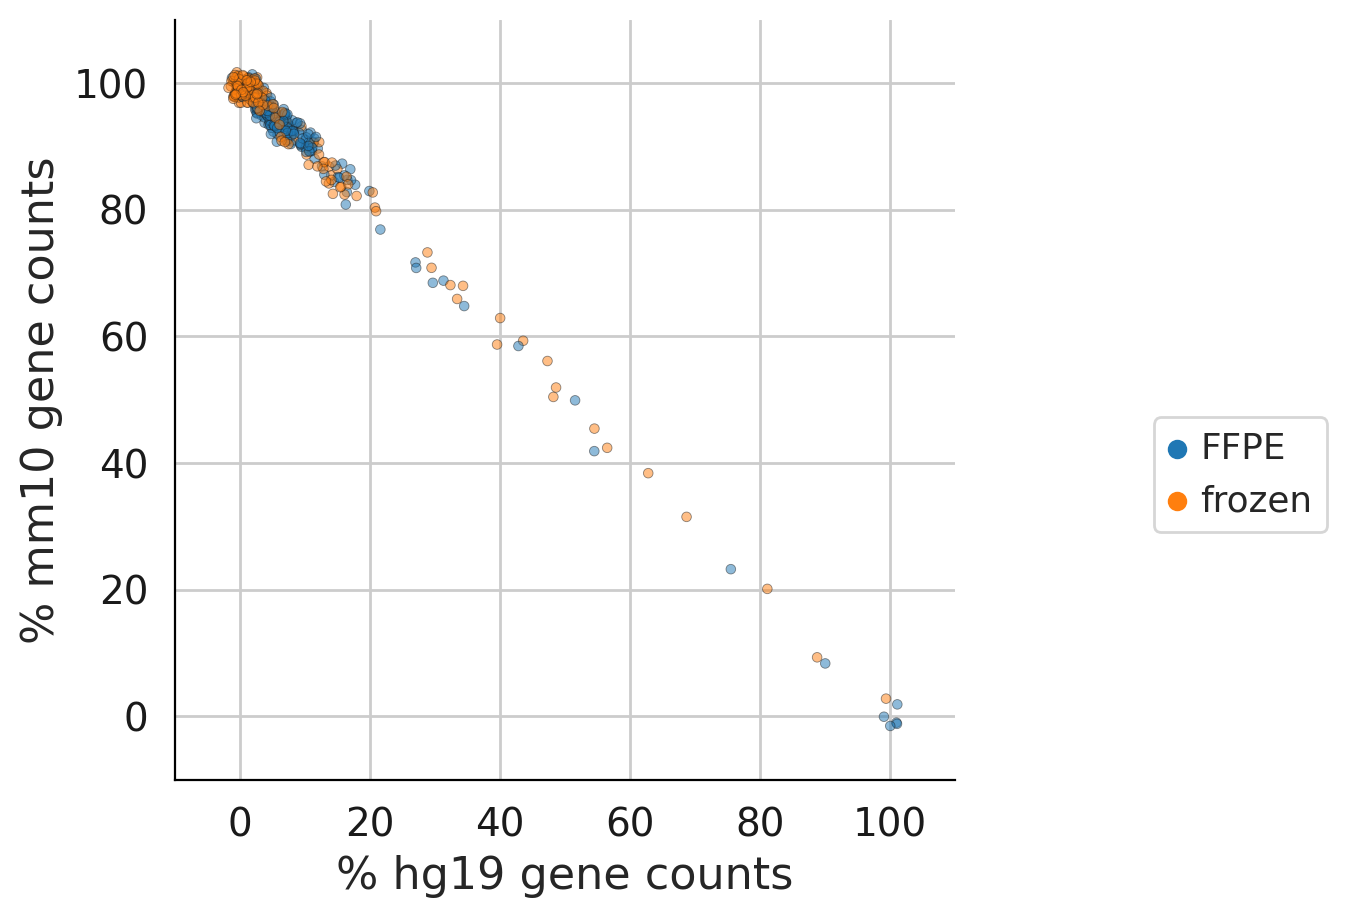

In [5]:
# subset to only mouse genes
ad_frozen_hg19, ad_frozen_mm10, ad_frozen_all = ffpe.split_hg19_and_mm10(ad_ffpe_frozen)
ffpe.scatter_hg19_vs_mm10(ad_frozen_all, hue_var='library_type', savefig=True)

In [6]:
sc.pp.filter_cells(ad_frozen_all, min_genes=300)

In [8]:
ffpe_aligned = ad_frozen_all[ad_frozen_all.obs['library_type']=='FFPE'].obs['percent_mm10']
frozen_aligned = ad_frozen_all[ad_frozen_all.obs['library_type']=='frozen'].obs['percent_mm10']
print(np.median(ffpe_aligned))
print(np.median(frozen_aligned))

94.22574
98.41047


In [10]:
from scipy import stats
stats.mannwhitneyu(ffpe_aligned, frozen_aligned)

MannwhitneyuResult(statistic=8932.0, pvalue=4.203790020998099e-12)

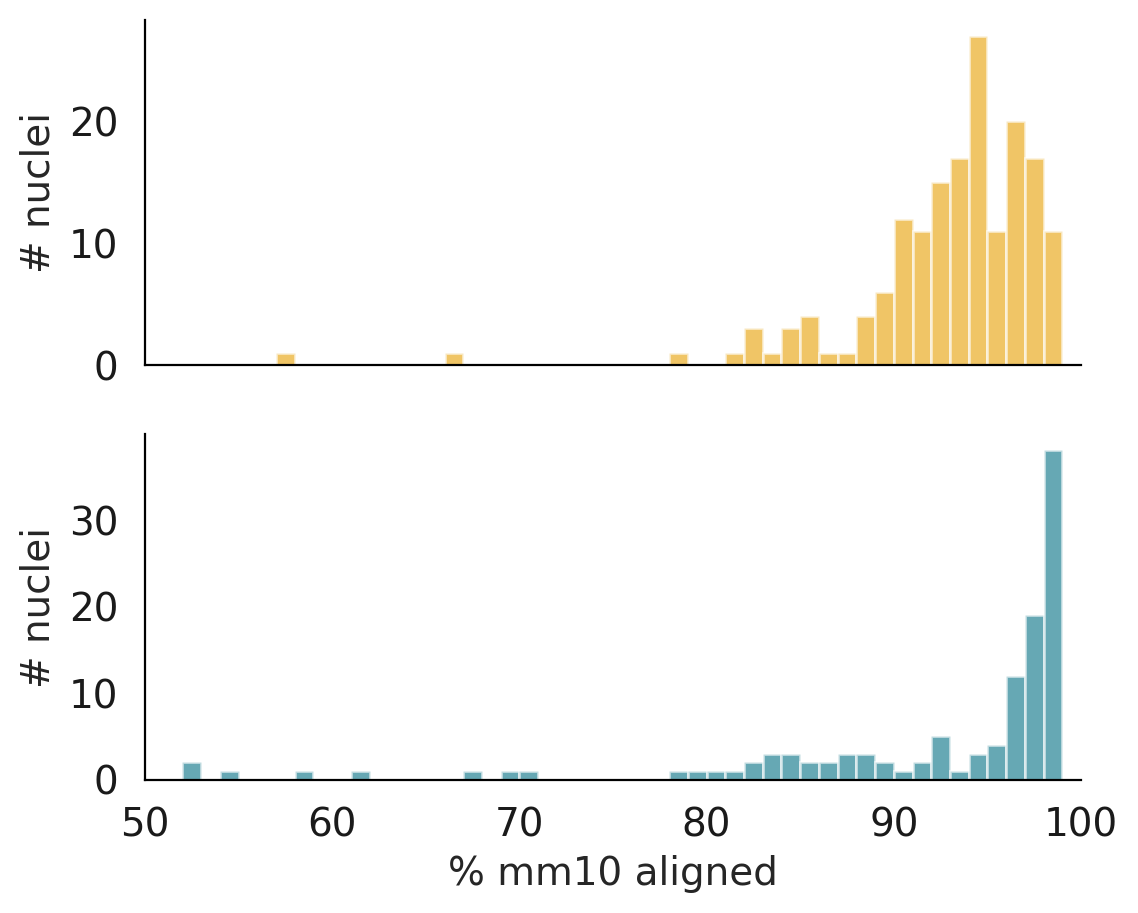

In [11]:
sc.set_figure_params(figsize=(6,5), dpi=100, frameon=False)

f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
bins = np.arange(0,100,1)
plt.grid(False)
ax1.hist(ffpe_aligned, 
                 color='#E69F00', 
                 bins=bins,
                 alpha=0.6)
ax1.grid(False)
ax1.set_ylabel('# nuclei')
ax2.hist(frozen_aligned, 
                 color='#006E82', 
                 bins=bins, 
                 alpha=0.6)
ax2.grid(False)
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax2.spines.right.set_visible(False)
ax2.spines.top.set_visible(False)

plt.xlabel('% mm10 aligned')
plt.ylabel('# nuclei')

plt.xlim([50,100])
# plt.xticks([2,3,4])
# ax.set_xticklabels(['10^2','10^3','10^4'])
plt.yticks(np.arange(0,32,10))

plt.savefig('%s/histogram_FFPE_vs_frozen_perc_mm10.pdf' %sc.settings.figdir, 
                bbox_inches='tight')

In [12]:
print(np.median(ad_frozen_all[ad_frozen_all.obs['library_type']=='frozen'].obs['percent_mm10']))
print(np.median(ad_frozen_all[ad_frozen_all.obs['library_type']=='FFPE'].obs['percent_mm10']))

98.41047
94.22574


In [13]:
ad_frozen_mm10 = ad_frozen_mm10[ad_frozen_all.obs.index].copy()

Filter genes and nuclei

In [14]:
# remove lowly aligned genes
ad_frozen_mm10 = ad_frozen_mm10[ad_frozen_all.obs['percent_mm10']>90,:].copy()
ad_frozen_mm10.var_names_make_unique()

# subset only mouse alignment to single nuclei
ad_ffpe_frozen = ad_frozen_mm10[ad_frozen_mm10.obs['num_nuclei']==1,:].copy()

# remove low counts
ad_ffpe_frozen = ad_ffpe_frozen[ad_ffpe_frozen.obs['n_counts']>1000].copy()

In [20]:
ad_ffpe_frozen.obs['n_genes_mm10'] = ad_ffpe_frozen.X.astype(bool).sum(axis=1)

### Downsample

In [36]:
# downsample counts - different for each nuclei

# downsample_lim = 10000

downsample_lim = np.median(ad_ffpe_frozen[ad_ffpe_frozen.obs['library_type']=='FFPE'].obs['n_counts_mm10'])
downsample_lim

47887.0

In [37]:
ff = ad_ffpe_frozen.copy()

sc.pp.downsample_counts(ff, counts_per_cell=int(downsample_lim))

# calculate downsampled n_genes and n_counts
ff.obs['n_genes_ds'] = ff.X.astype(bool).sum(axis=1)
ff.obs['n_counts_ds'] = ff.X.sum(axis=1)

### Compare genes detected in original vs. downsampled data

In [38]:
print(np.median(ad_ffpe_frozen[ad_ffpe_frozen.obs['library_type']=='frozen'].obs['n_genes_mm10']))
print(np.median(ad_ffpe_frozen[ad_ffpe_frozen.obs['library_type']=='FFPE'].obs['n_genes_mm10']))

4382.0
1635.0


In [40]:
print(np.median(ff[ff.obs['library_type']=='frozen'].obs['n_genes_ds']))
print(np.median(ff[ff.obs['library_type']=='FFPE'].obs['n_genes_ds']))

2927.0
1473.0


/home/jupyter/.local/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


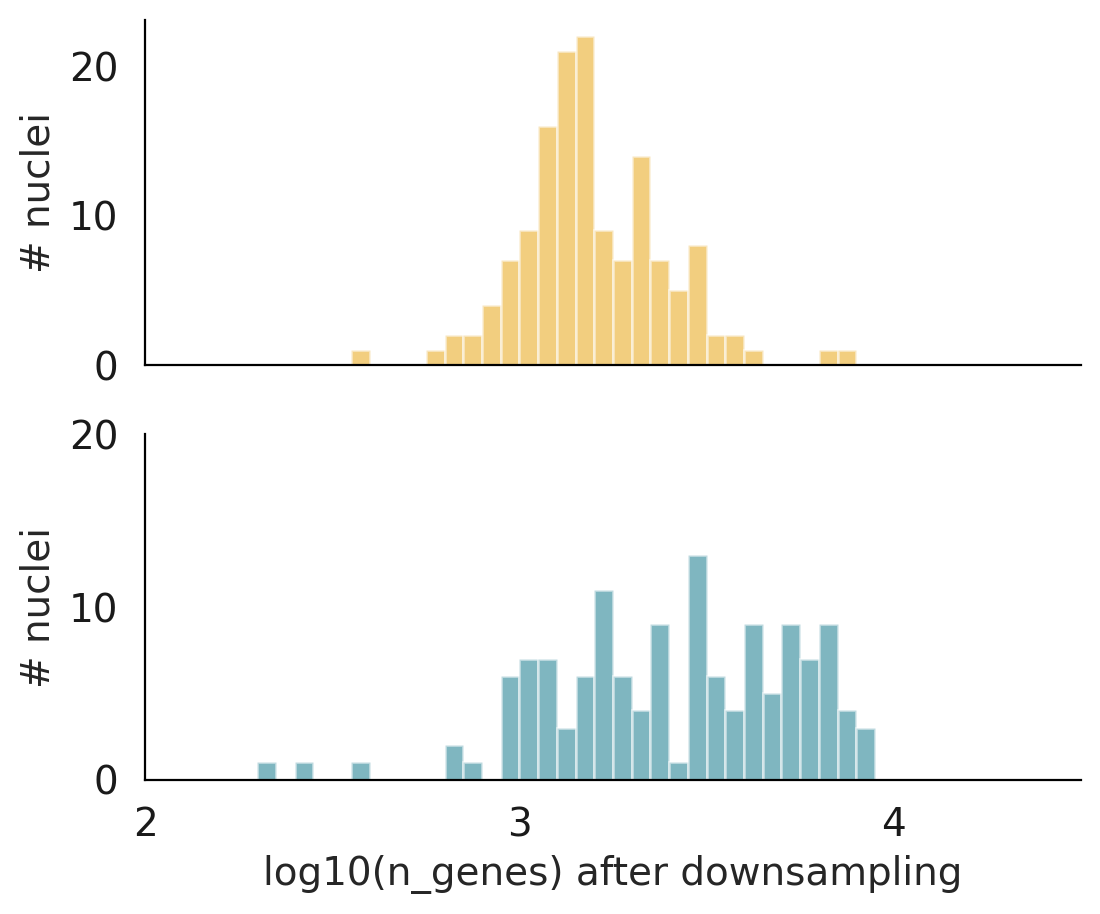

In [44]:
ff.obs['log10_counts'] = np.log10(ff.obs['n_counts_ds'])
ff.obs['log10_genes'] = np.log10(ff.obs['n_genes_ds'])

sc.set_figure_params(figsize=(6,5), dpi=100, frameon=False)

f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
bins = np.arange(2,4,0.05)
ax1.hist(ff[ff.obs['library_type']=='FFPE'].obs['log10_genes'], 
                 color='#E69F00', bins=bins, alpha=0.5)
ax1.grid(False)
ax1.set_ylabel('# nuclei')
ax1.set_yticks([0,10,20])

ax2.hist(ff[ff.obs['library_type']=='frozen'].obs['log10_genes'], 
                 color='#006E82', bins=bins, alpha=0.5)
ax2.set_yticks([0,10,20])

plt.grid(None)
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax2.spines.right.set_visible(False)
ax2.spines.top.set_visible(False)

plt.xticks([2,3,4])
plt.xlim([2,4.5])
# ax1.set_xticklabels(['10^2','10^3','10^4'])

plt.xlabel('log10(n_genes) after downsampling')
plt.ylabel('# nuclei')

plt.savefig('%s/histogram_FFPE_vs_frozen_genes_downsampled_counts.pdf' %sc.settings.figdir, 
                bbox_inches='tight')

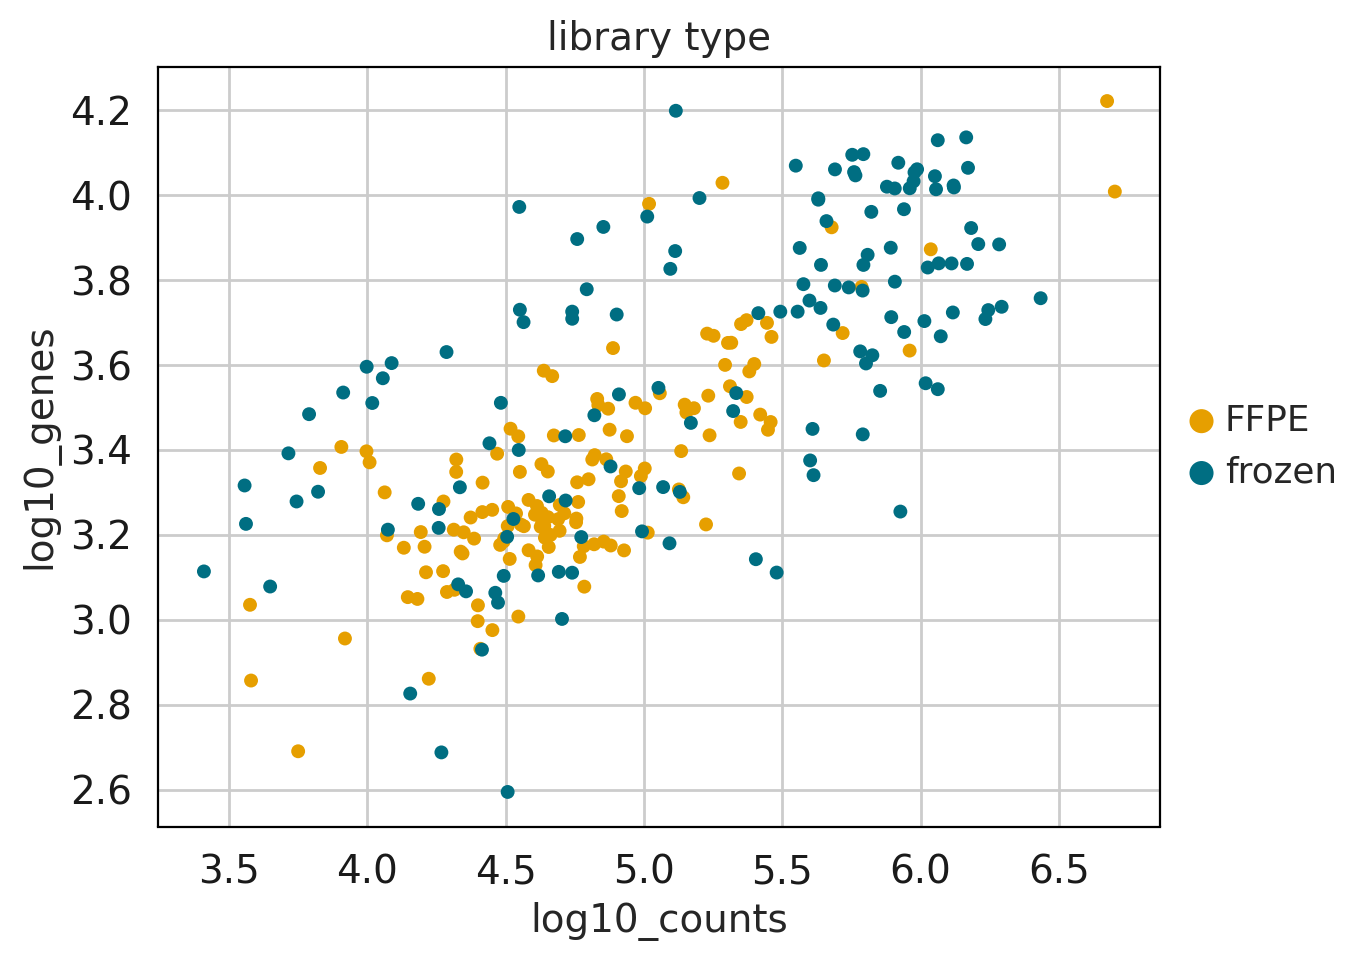

In [25]:
ad_plot = sc.pp.subsample(ad_ffpe_frozen, fraction=1, copy=True)
ad_plot.obs['log10_counts'] = np.log10(ad_plot.obs['n_counts'])
ad_plot.obs['log10_genes'] = np.log10(ad_plot.obs['n_genes'])

sc.pl.scatter(ad_plot, x='log10_counts', y='log10_genes', color='library_type', 
              palette=['#E69F00', '#006E82'], size=100, save='_compare_frozen_vs_FFPE')

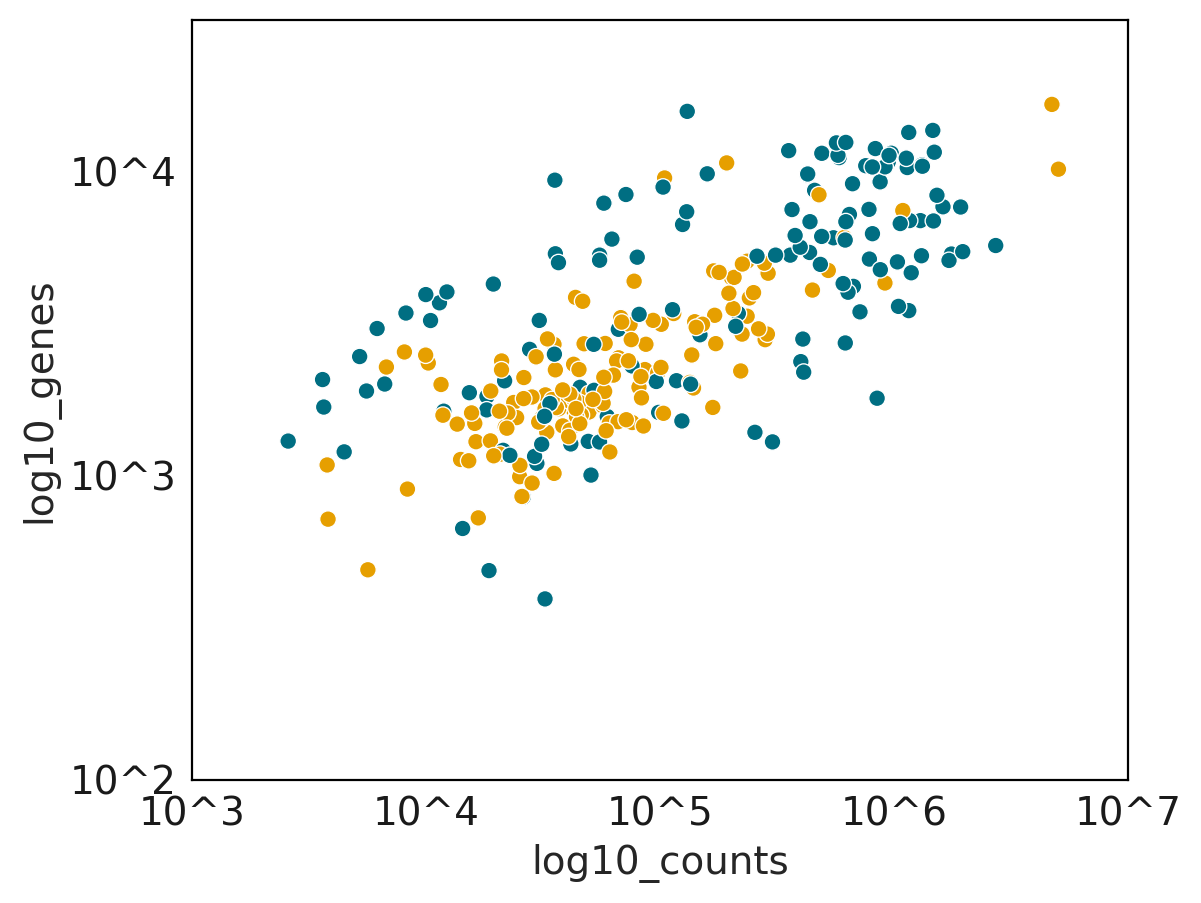

In [26]:
import seaborn as sns

ad_plot = sc.pp.subsample(ad_ffpe_frozen, fraction=1, copy=True)
ad_plot.obs['log10_counts'] = np.log10(ad_plot.obs['n_counts'])
ad_plot.obs['log10_genes'] = np.log10(ad_plot.obs['n_genes'])

ax = plt.subplot()
sns.scatterplot(data=ad_plot.obs, x='log10_counts', y='log10_genes', 
                hue='library_type', 
                palette=['#E69F00', '#006E82'], 
                legend=False)
plt.grid(False)
plt.xlim([3, 7])
plt.xticks([3,4,5,6,7])
ax.set_xticklabels(['10^3','10^4','10^5','10^6','10^7'])
plt.ylim([2,4.5])
plt.yticks([2,3,4])
ax.set_yticklabels(['10^2','10^3','10^4'])
ax.tick_params(direction='out', length=2, width=2, color='k')

plt.savefig('%s/scatter_FFPE_vs_frozen_genes_counts.pdf' %sc.settings.figdir, bbox_inches='tight')

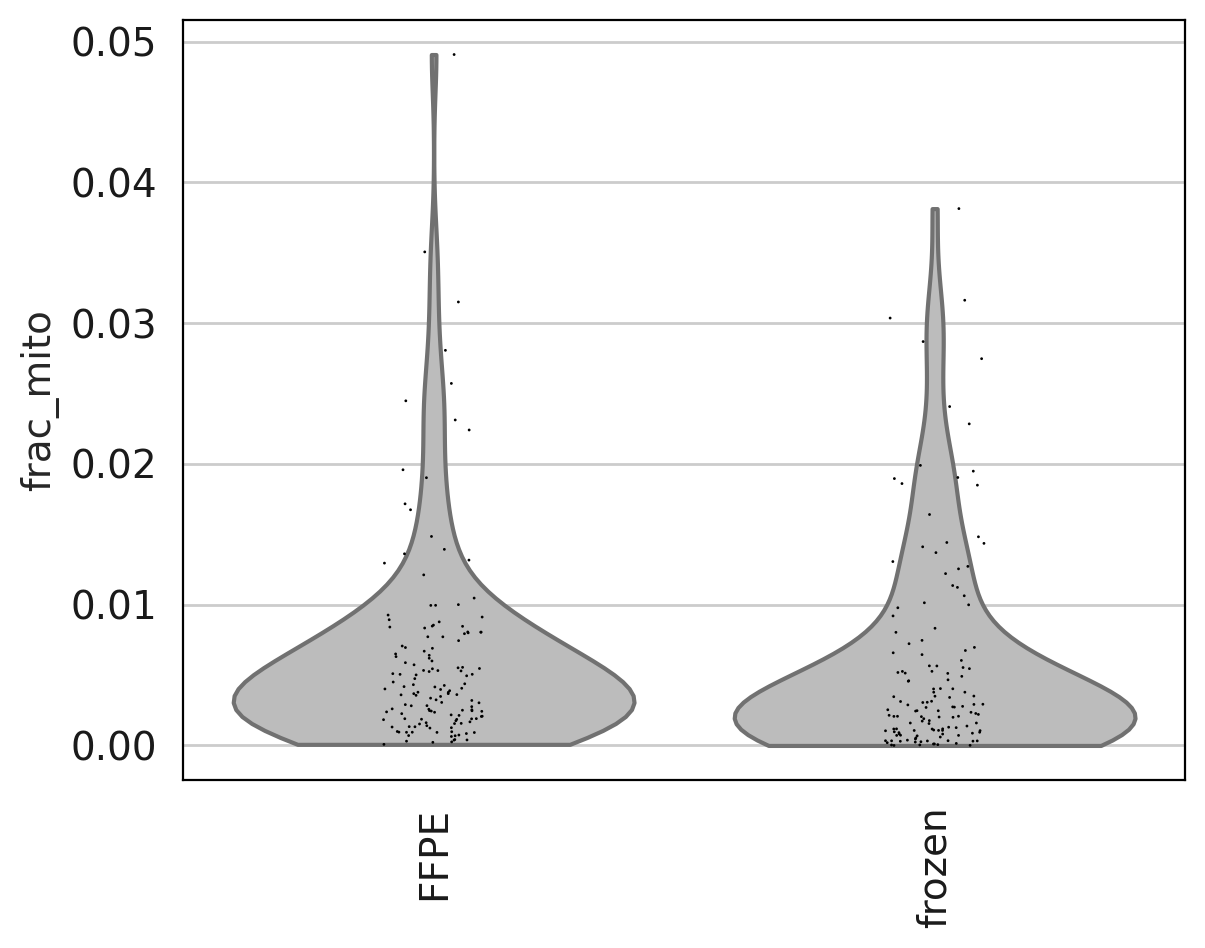

0.0027772475
0.004013113


In [27]:
ffpe.calc_mito_ncounts(ad_plot, case='mouse')
sc.pl.violin(ad_plot, keys=['frac_mito'], groupby='library_type', rotation=90, 
             palette=['#bcbcbc'], save='_frozen_vs_FFPE_frac_mito')
print(np.median(ad_plot[ad_plot.obs['library_type']=='frozen'].obs['frac_mito']))
print(np.median(ad_plot[ad_plot.obs['library_type']=='FFPE'].obs['frac_mito']))